# Imports

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.9.0+cu126
Using device: cpu


# Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import shutil

source_path = "/content/drive/MyDrive/Kaggle Competition/Dataset/digit-recognizer.zip"
dest_path = "/content/data.zip"

shutil.copy(source_path, dest_path)
print("✅ File copied to Colab temporary storage.")

✅ File copied to Colab temporary storage.


In [4]:
import zipfile

with zipfile.ZipFile(dest_path, 'r') as zip_ref:
    zip_ref.extractall("/content/data")
print("✅ File extracted successfully.")

✅ File extracted successfully.


In [5]:
import os

os.remove("/content/data.zip")
print("✅ ZIP file deleted successfully.")

✅ ZIP file deleted successfully.


In [6]:
class MNISTDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.data = pd.read_csv(csv_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        if 'label' in row.index:
            label = int(row['label'])
            pixels = row.values[1:]
        else:
            label = None
            pixels = row.values

        image = pixels.reshape(28, 28).astype(np.uint8)

        if self.transform:
            image = self.transform(image)

        if label is not None:
            return image, label
        else:
            return image, torch.tensor([])

Label: 0
Tensor Shape: torch.Size([1, 28, 28])


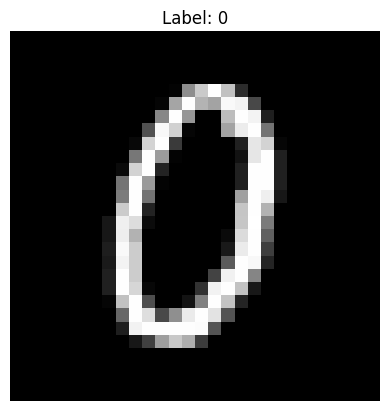

In [8]:
base_transform = transforms.Compose([
    transforms.ToTensor()
])

train_csv_path = '/content/data/train.csv'
train_dataset = MNISTDataset(train_csv_path, transform=base_transform)

image_tensor, label = train_dataset[5]

print(f"Label: {label}")
print(f"Tensor Shape: {image_tensor.shape}")

plt.imshow(image_tensor.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [10]:
BATCH_SIZE = 64
TRAIN_RATIO = 0.8

total_size = len(train_dataset)
train_size = int(TRAIN_RATIO * total_size)
val_size = total_size - train_size

print(f"Total Images: {total_size}")
print(f"Training Set: {train_size}")
print(f"Validation Set: {val_size}")

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

Total Images: 42000
Training Set: 33600
Validation Set: 8400


# Model

In [11]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNNModel().to(device)
print(model)

CNNModel(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# model = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),

#     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2, stride=2),

#     nn.Flatten(),
#     nn.Linear(64 * 7 * 7, 128),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(128, 10)
# )

# model = model.to(device)
# print(model)

# Loss & Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train

In [14]:
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_subset)
    epoch_train_acc = 100 * correct_train / total_train

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_subset)
    epoch_val_acc = 100 * correct_val / total_val

    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%")

Epoch [1/10] | Train Loss: 0.1213, Acc: 96.37% | Val Loss: 0.0587, Acc: 98.17%
Epoch [2/10] | Train Loss: 0.0893, Acc: 97.33% | Val Loss: 0.0508, Acc: 98.31%
Epoch [3/10] | Train Loss: 0.0702, Acc: 97.85% | Val Loss: 0.0464, Acc: 98.64%
Epoch [4/10] | Train Loss: 0.0621, Acc: 98.12% | Val Loss: 0.0485, Acc: 98.51%
Epoch [5/10] | Train Loss: 0.0543, Acc: 98.38% | Val Loss: 0.0441, Acc: 98.69%
Epoch [6/10] | Train Loss: 0.0451, Acc: 98.59% | Val Loss: 0.0425, Acc: 98.79%
Epoch [7/10] | Train Loss: 0.0403, Acc: 98.74% | Val Loss: 0.0430, Acc: 98.76%
Epoch [8/10] | Train Loss: 0.0396, Acc: 98.79% | Val Loss: 0.0416, Acc: 98.74%
Epoch [9/10] | Train Loss: 0.0325, Acc: 98.93% | Val Loss: 0.0440, Acc: 98.76%
Epoch [10/10] | Train Loss: 0.0304, Acc: 99.00% | Val Loss: 0.0452, Acc: 98.74%


# Visualization

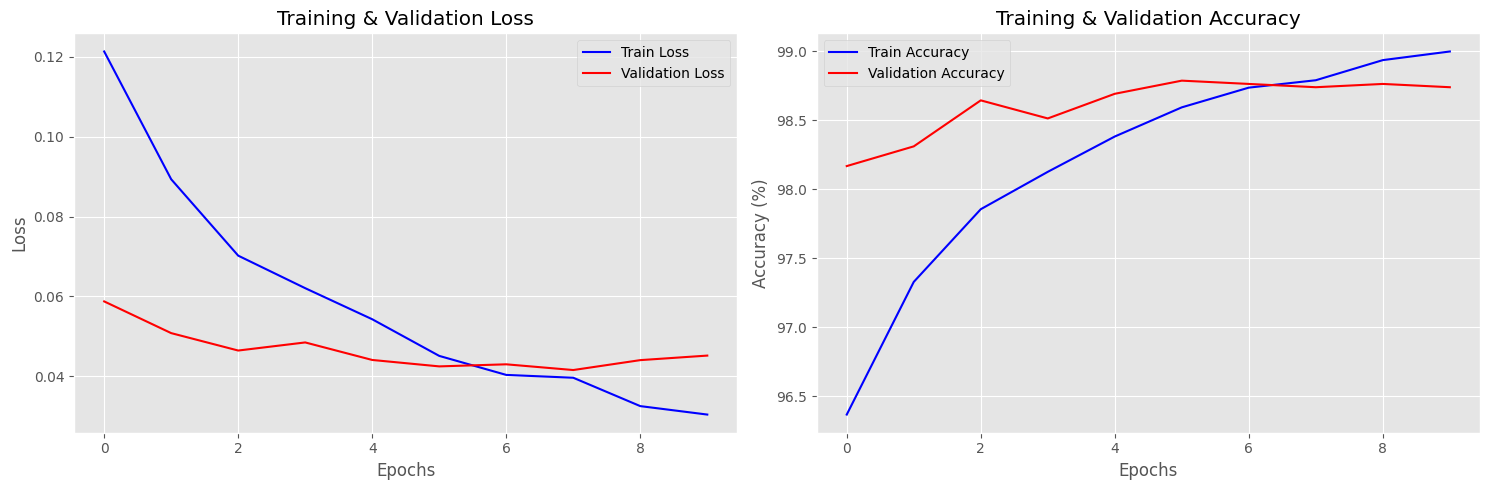

In [15]:
plt.style.use('ggplot')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_accuracies, label='Train Accuracy', color='blue')
ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.tight_layout()
plt.show()

# Test Submission

In [17]:
test_csv_path = '/content/data/test.csv'

test_dataset = MNISTDataset(test_csv_path, transform=base_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

sample_test_img, _ = test_dataset[0]
print(f"Test Image Shape: {sample_test_img.shape}")

Test Image Shape: torch.Size([1, 28, 28])


In [18]:
model.eval()

all_preds = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())

submission_df = pd.DataFrame({
    'ImageId': range(1, len(all_preds) + 1),
    'Label': all_preds
})

print(submission_df.head())

submission_df.to_csv('submission.csv', index=False)

   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3
